In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import yaml
#for ipynb
%matplotlib inline

In [2]:
in_dict = {'short-fragments':'../ATAC_short_fragment_sizes/results',
           'all-fragments':'../ATAC_all_fragment_sizes/results',
          'CNA-corrected':'../CNA_correction_100kb_ATAC_np/results'}

samples_yaml = '../ATAC_all_fragment_sizes/config/samples.GC.yaml'
metadata_path = '../../metadata/MBC/merged_tables_revisions1/merged_key_metadata.txt'

with open(samples_yaml, 'r') as f:
    samples = yaml.safe_load(f)
samples = samples['samples']
samples = list(samples.keys())  
    
in_files = {}
for group in in_dict.keys():
    in_dir = in_dict[group]
    in_files[group] = []
    for sample in samples:
        in_files[group].append(in_dir+'/'+sample+'/'+sample+'.GC_corrected.coverage.tsv')
    print(group,len(in_files[group]))    

short-fragments 254
all-fragments 254
CNA-corrected 254


In [3]:
#get columns with coverage data
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [4]:
#import data
start_time = time.time()
data = pd.DataFrame()
for group in in_files.keys():
    for i,file in enumerate(in_files[group]):
        if i%100==0:
            print(i,'importing',file,np.round(time.time()-start_time))
        current = pd.read_csv(file,sep='\t')
        current['site_group'] = group
        data = data.append(current, ignore_index=True)
        

0 importing ../ATAC_short_fragment_sizes/results/MBC_1041_1_ULP/MBC_1041_1_ULP.GC_corrected.coverage.tsv 0.0
100 importing ../ATAC_short_fragment_sizes/results/MBC_1272_ULP/MBC_1272_ULP.GC_corrected.coverage.tsv 1.0
200 importing ../ATAC_short_fragment_sizes/results/MBC_1421_3_ULP/MBC_1421_3_ULP.GC_corrected.coverage.tsv 1.0
0 importing ../ATAC_all_fragment_sizes/results/MBC_1041_1_ULP/MBC_1041_1_ULP.GC_corrected.coverage.tsv 2.0
100 importing ../ATAC_all_fragment_sizes/results/MBC_1272_ULP/MBC_1272_ULP.GC_corrected.coverage.tsv 3.0
200 importing ../ATAC_all_fragment_sizes/results/MBC_1421_3_ULP/MBC_1421_3_ULP.GC_corrected.coverage.tsv 4.0
0 importing ../CNA_correction_100kb_ATAC_np/results/MBC_1041_1_ULP/MBC_1041_1_ULP.GC_corrected.coverage.tsv 4.0
100 importing ../CNA_correction_100kb_ATAC_np/results/MBC_1272_ULP/MBC_1272_ULP.GC_corrected.coverage.tsv 5.0
200 importing ../CNA_correction_100kb_ATAC_np/results/MBC_1421_3_ULP/MBC_1421_3_ULP.GC_corrected.coverage.tsv 6.0


In [5]:
#get the subtype data
metadata = pd.read_csv(metadata_path, sep='\t')
metadata_columns = ['sample','patient_id','revisions_ER_status_binary','ulp_wgs_coverage','tumor_fraction','first_passing_sample']
metadata = metadata[metadata_columns]

#merge with data
print(len(data))
data = data.merge(metadata, on = 'sample')
print(len(data['sample'].unique()))


3048
254


In [6]:
data['number_of_sites'].unique()

array([22365,  9930, 18240, 19347])

In [7]:
print(len(data['site_name'].unique()))
data['site_name'].unique()

4


array(['ER_neg_heme.5e-4_qval', 'ER_pos_heme.5e-4_qval',
       'ER_pos_specific.5e-4_qval', 'ER_neg_specific.5e-4_qval'],
      dtype=object)

In [8]:
#get the key columns
data = data[metadata_columns+['site_name','correction','site_group',
                              'central_coverage','amplitude','mean_coverage']+str_plot_columns]
print(len(data))

site_groups = in_dict.keys()

site_names = data['site_name'].unique()

for group,df in data.groupby('site_group'):
    print(group,len(df['site_name'].unique()))

    #df.to_csv('merged_data/'+group+'_data_with_features.txt', sep='\t', index=False)
    
    #reformat for logistic regression
    reformatted = df[metadata_columns+['site_name','site_group','central_coverage','amplitude','mean_coverage']]
    reformatted = reformatted.set_index(metadata_columns+['site_group','site_name']).unstack()
    new_column_names = []
    for item in reformatted.columns.values:
        new_column_names.append('_'.join(item))
    reformatted.columns = new_column_names
    reformatted.to_csv('merged_data/'+group+'_reformatted.txt', sep='\t')
    print(reformatted.shape)

3048
CNA-corrected 4
(254, 12)
all-fragments 4
(254, 12)
short-fragments 4
(254, 12)


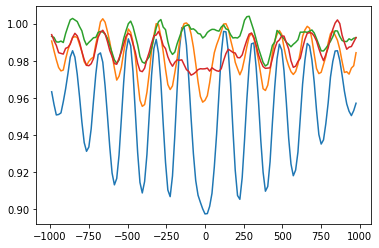

In [9]:
#plot
for site_name in data['site_name'].unique():
    current = data[data['site_name']==site_name][str_plot_columns].mean()
    plt.plot(plot_columns,current, label=site_name)
    
# plt.legend()



fft real -0.3572058186197712
fft imag 0.026668325705016406
fft magn 0.3581999392123479
sum x coords -0.3572058186197844
sum y coords 0.026668325704994222
magnitude: 0.3581999392123594


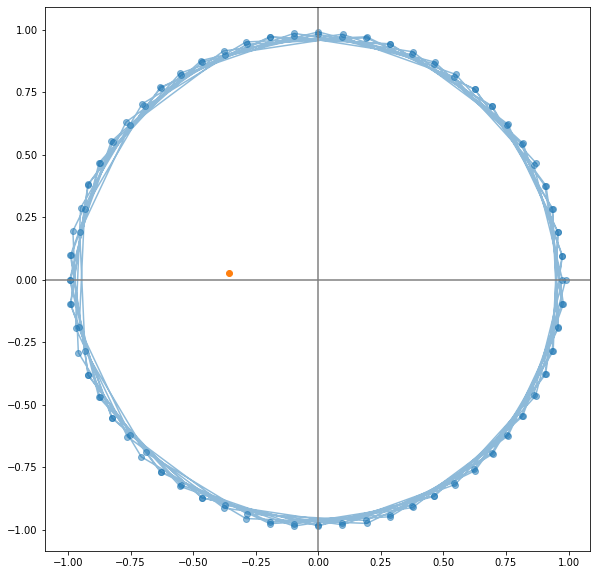

In [10]:
fft_columns = np.arange(-960,960,15)
str_fft_columns = [str(m) for m in fft_columns]

#plot out what the fft is doing for a given frequency
demo_res = np.fft.fft(current[str_fft_columns])
demo_signal = current[str_fft_columns]

frequency = 10
print('fft real', demo_res[frequency].real)
print('fft imag', demo_res[frequency].imag)
print('fft magn',np.abs(demo_res[frequency]))

#get angles for rotation
angles = np.linspace(0,2*np.pi,len(demo_signal)+1)
angles = -angles[0:-1]

#wrapped at frequency
heights = np.sin(angles*frequency)*demo_signal
widths = np.cos(angles*frequency)*demo_signal
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(widths,heights, alpha = 0.5)
ax.scatter(widths,heights, alpha = 0.5)
ax.set_aspect('equal')
ax.scatter(sum(widths),sum(heights))
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
print('sum x coords',sum(widths))
print('sum y coords',sum(heights))
print('magnitude:',np.sqrt(sum(widths)**2+sum(heights)**2))

In [11]:
# from scipy.signal import find_peaks
# plt.plot(fft_columns,current)
# peaks =  [fft_columns[m] for m in find_peaks(current)[0]]
# plt.scatter(peaks,[.99 for m in peaks])
# print(peaks)

# spacing = []
# for i in range(len(peaks)-1):
#     spacing.append(peaks[i+1]-peaks[i])
# np.mean(spacing)